## **Tarea Práctica** - Regresion Polinomial & Feature Engineering

#### Librerias a utilizar

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta
import math
from sklearn.preprocessing import PolynomialFeatures

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


### **Parte 1**

#### Carga de Datos

In [3]:
data_covid = pd.read_csv('covid_19.csv')

#### Fauture Engineering

In [293]:
data_covid["Date"] = pd.to_datetime(data_covid["Date"], infer_datetime_format = True)
data_filtered = data_covid[(data_covid["Country/Region"] == 'Guatemala') & (data_covid["Confirmed"] > 0) & (data_covid["Date"]>="2020-03-22")].copy()
data_filtered["Confirmed_converted"] = np.log(data_filtered["Confirmed"])
data_filtered["Count_days"] = max(data_filtered["Date"])-data_filtered["Date"]
data_filtered["Number_day"] = pd.to_timedelta(max(data_filtered["Count_days"])-data_filtered["Count_days"]).dt.days

In [366]:
data_filtered.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Confirmed_converted,Count_days,Number_day
16023,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19,1,0,2.944439,58 days,0
16288,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20,1,0,2.995732,57 days,1
16553,NaN,Guatemala,15.7835,-90.2308,2020-03-24,21,1,0,3.044522,56 days,2
16818,NaN,Guatemala,15.7835,-90.2308,2020-03-25,24,1,4,3.178054,55 days,3
17083,NaN,Guatemala,15.7835,-90.2308,2020-03-26,25,1,4,3.218876,54 days,4


#### Definición de clases para la construcción del Modelo de Regresión Lineal

In [286]:
class Linear_regression:
    
    def __init__(self):
        tf.reset_default_graph()
        self.values = np.array([0.1,2.2])
        init = tf.constant_initializer(self.values)
        self.parameters_vector = tf.get_variable("parameters", dtype=tf.float32, shape=[2,1], initializer=init)
        
    def cost(self, y_train, y_predict):
        with tf.name_scope("cost"):
            return 1/2*tf.reduce_mean(tf.math.square(y_train - y_predict))
    
    def predict(self, x):
        with tf.name_scope("predict"):
            ones = tf.cast(tf.ones_like(x), tf.float32)
            return tf.matmul(tf.stack((x,ones), axis=-1), self.parameters_vector)
    
    def gradient(self, error_cost, y_train, y_predict):
        return tf.gradients(error_cost, self.parameters_vector)
    
    def update_parameters(self, error_cost, y_train, y_predict, learning_rate):
        with tf.name_scope("gradient"):
            gradient_vector = self.gradient(error_cost, y_train, y_predict)
        with tf.name_scope("update_params"):
            return tf.assign(self.parameters_vector, self.parameters_vector - learning_rate*gradient_vector[0])

In [296]:
class Linear_model:
    
    def __init__(self, array):
        self.tamano_data_set = len(array)        
        self.lr = Linear_regression()
        self.params = self.lr.values
        self.x = array["Number_day"].to_numpy()/10
        self.y = array["Confirmed_converted"].to_numpy()

    def training(self, learning_rate, steps):
        plt.scatter(self.x,self.y)
        x_train = tf.placeholder(tf.float32,[self.tamano_data_set],"x_train")
        y_train = tf.placeholder(tf.float32,[self.tamano_data_set],"y_train")

        y_predict = self.lr.predict(self.x)
        error = self.lr.cost(y_train, y_predict)
        update_parameters_vector = self.lr.update_parameters(error, y_train, y_predict, learning_rate)

        with tf.train.MonitoredSession() as session:
            feed_dict = {x_train:self.x, y_train:self.y}
            for step in range(steps):
                session.run(update_parameters_vector,feed_dict=feed_dict)
                prediction = session.run(y_predict,feed_dict=feed_dict)
                plt.plot(self.x,prediction)
            self.params = session.run(self.lr.parameters_vector,feed_dict=feed_dict)
            plt.title("Parámetros finales: m={} b={}".format(self.params[0],self.params[1]))

        plt.legend()
        plt.show()

#### Objeto de la clase ***Linear_model***

In [297]:
lm = Linear_model(data_filtered)

#### Gráfica de Dispersión

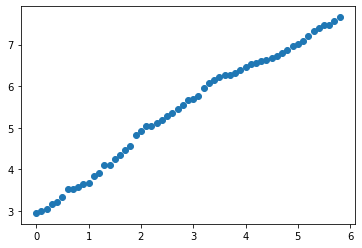

In [298]:
plt.scatter(lm.x,lm.y)
plt.show()

#### Entrenamiento del Modelo con lr=0.0025 y 160 iteraciones

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


No handles with labels found to put in legend.


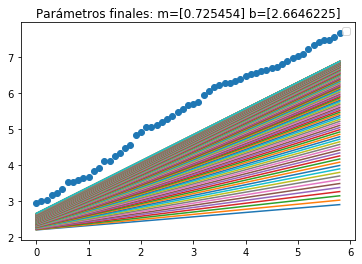

In [299]:
lm.training(0.0025, 160)

#### Función ***get_number_day***

Esta función fue desarrollada con la intención de experimentar con cualquier fecha devolviendo su equivalente en número entero.

In [291]:
def get_number_day(date, data):    
    return max(pd.to_timedelta(datetime.strptime(date, "%Y-%m-%d") - data["Date"]).dt.days)

#### Predicción de casos reportados para **2020-06-06**

In [292]:
date_string = "2020-06-06"
number_day = get_number_day(date_string, data_filtered)
model = lm.params[0]*(number_day/10) + lm.params[1]
prediction = int(pow(math.e,model[0]))
print("Se predicen",prediction,"casos confirmados para",date_string)

Se predicen 3561 casos confirmados para 2020-06-06


#### **Conclusión** 

Durante el experimento se observó que si se continuaban incrementando las iteraciones o el learning rate, disminuía la pendiente de la recta dando un menor grado de predicción, se identifico que con esto parametros se lograba una tendencia que podría ajustarse al modelo.

### **Parte 2**

#### Carga de Datos

In [391]:
data_wine = pd.read_csv('winequality-red.csv')

#### Escalado y Normalización de Features

In [392]:
data_wine["quality_scaled"] = data_wine["quality"]/10
data_wine["alcohol_normalized"] = (data_wine["alcohol"]-np.mean(data_wine["alcohol"]))/np.std(data_wine["alcohol"])
data_wine["sulphates_normalized"] = (data_wine["sulphates"]-np.mean(data_wine["sulphates"]))/np.std(data_wine["sulphates"])
data_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_scaled,alcohol_normalized,sulphates_normalized
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.5,-0.960246,-0.579207
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0.5,-0.584777,0.128950
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0.5,-0.584777,-0.048089
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0.6,-0.584777,-0.461180
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.5,-0.960246,-0.579207


#### Análisis Exploratorio

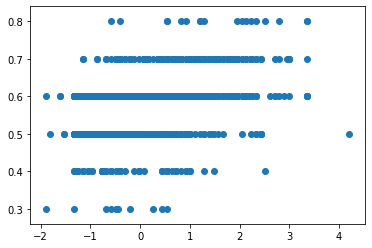

In [393]:
plt.scatter(data_wine["alcohol_normalized"],data_wine["quality_scaled"])
plt.show()

In [394]:
np.corrcoef(data_wine["alcohol_normalized"],data_wine["quality_scaled"])[0,1]

0.4761663240011359

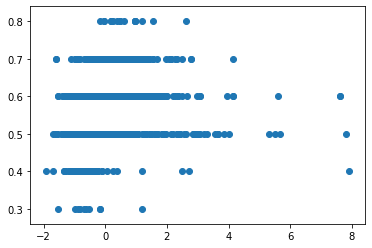

In [395]:
plt.scatter(data_wine["sulphates_normalized"],data_wine["quality_scaled"])
plt.show()

In [396]:
np.corrcoef(data_wine["sulphates_normalized"],data_wine["quality_scaled"])[0,1]

0.2513970790692612

#### Selección de Feautres

Se han seleccionado las variables "Alcohol" y "Sulphates" por el nivel de correlación con la variable dependiente.

#### Transformación ***sklearn.preprocessing.PolynomialFeatures***

In [517]:
feautures = data_wine[["alcohol_normalized","sulphates_normalized"]].values
polynomial_features = PolynomialFeatures(2)
array_x = polynomial_features.fit_transform(feautures)
array_y = data_wine[["quality_scaled"]].values

#### Definición de clases para la construcción del Modelo de Regresión Polinomial

In [524]:
class Polynomial_regression:
    
    def __init__(self):
        tf.reset_default_graph()
        self.parameters_vector = tf.get_variable("parameters", dtype=tf.float32, shape=[6,1], initializer=tf.zeros_initializer())
        
    def cost(self, y_train, y_predict):
        with tf.name_scope("cost"):
            return 1/2*tf.reduce_mean(tf.math.square(y_train - y_predict))
    
    def predict(self, x):
        with tf.name_scope("predict"):
            x_cast = tf.cast(x,tf.float32)
            return tf.matmul(x_cast, self.parameters_vector)
    
    def gradient(self, error_cost, y_train, y_predict):
        return tf.gradients(error_cost, self.parameters_vector)
    
    def update_parameters(self, error_cost, y_train, y_predict, learning_rate):
        with tf.name_scope("gradient"):
            gradient_vector = self.gradient(error_cost, y_train, y_predict)
        with tf.name_scope("update_params"):
            return tf.assign(self.parameters_vector, self.parameters_vector - learning_rate*gradient_vector[0])

In [525]:
class Polynomial_model:
    
    def __init__(self, array_x, array_y):  
        self.lr = Polynomial_regression()
        self.x = array_x
        self.y = array_y

    def training(self, learning_rate, steps, feature):
        plt.scatter(self.x[:,feature],self.y)
        x_train = tf.placeholder(tf.float32,[None,6],"x_train")
        y_train = tf.placeholder(tf.float32,[None,1],"y_train")

        y_predict = self.lr.predict(self.x)
        error = self.lr.cost(y_train, y_predict)
        error_summary = tf.summary.scalar(name="errors",tensor=error)
        update_parameters_vector = self.lr.update_parameters(error, y_train, y_predict, learning_rate)

        with tf.train.MonitoredSession() as session:
            feed_dict = {x_train:self.x, y_train:self.y}
            writer = tf.summary.FileWriter("./graphs/"+datetime.now().strftime("%Y%m%d_%H%M%S")+"_lr="+str(learning_rate)+"_polinomio_grado=2", session.graph)
            for step in range(steps):
                e_summary = session.run(error_summary, feed_dict=feed_dict)
                session.run(update_parameters_vector,feed_dict=feed_dict)
                prediction = session.run(y_predict,feed_dict=feed_dict)
                writer.add_summary(e_summary, step)
                plt.plot(self.x,prediction)
            writer.close()

        plt.legend()
        plt.show()

#### Objeto de la clase ***Polynomial_model***

In [537]:
pm = Polynomial_model(array_x, array_y)

#### Entrenamiento del Modelo

lr=0.01, 5 iteraciones y el último parametro hace referencia a la variable "Alcohol" que posee el indice = 1

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


No handles with labels found to put in legend.


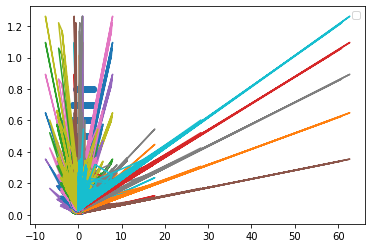

In [539]:
pm.training(0.01, 5, 1)

#### Grafo del Modelo

<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-3/master/graph.png">

#### Resultado - Tensorboard
<img src="https://raw.githubusercontent.com/estuardozapeta/Statistical-Learning-I-Tarea-3/master/error.png">

### **Conclusiones**

Según los datos arrojados por Tensorboard, parece que la tendencia es que mientras más reducido sea el learning rate, combinado con el equilibrio de pasos entre 5-15, el comportamiento del error tiede a 0, para el experimento con lr=0.012 se puede ver que el costo del error disminuyo con 15 pasos.